Chargement des données...
Données chargées.
Standardisation des données...
Données standardisées.
Exécution de l'ACP...
ACP terminée en 149.27 secondes.


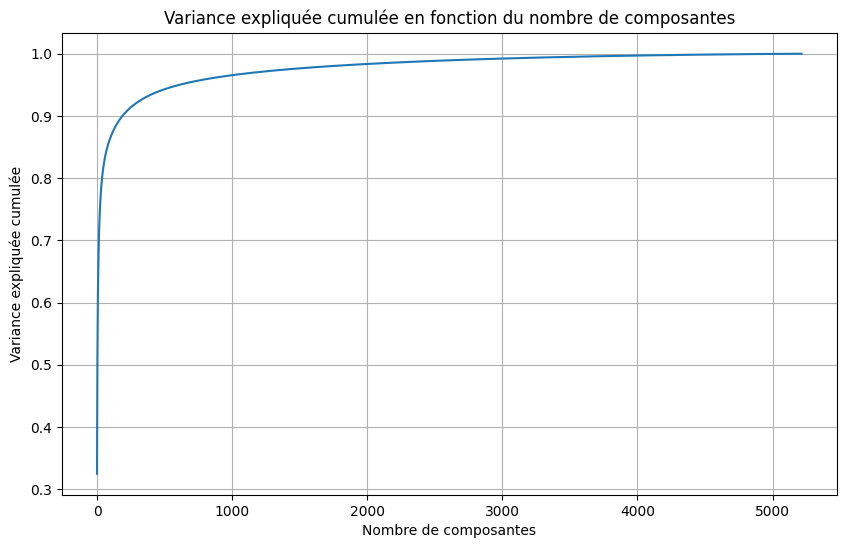

Nombre de composantes nécessaires pour 95% de variance: 611
Réduction de dimensionnalité: 50176 -> 611 (1.22%)


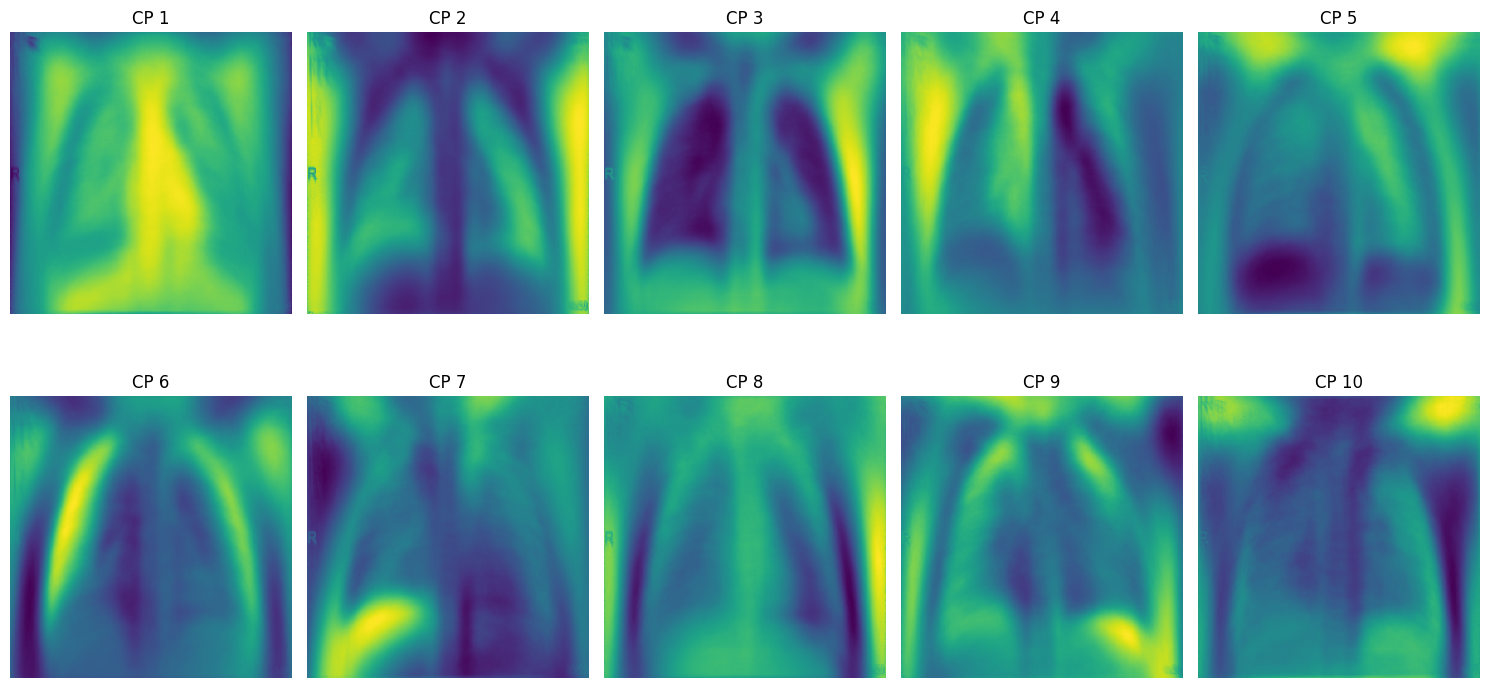

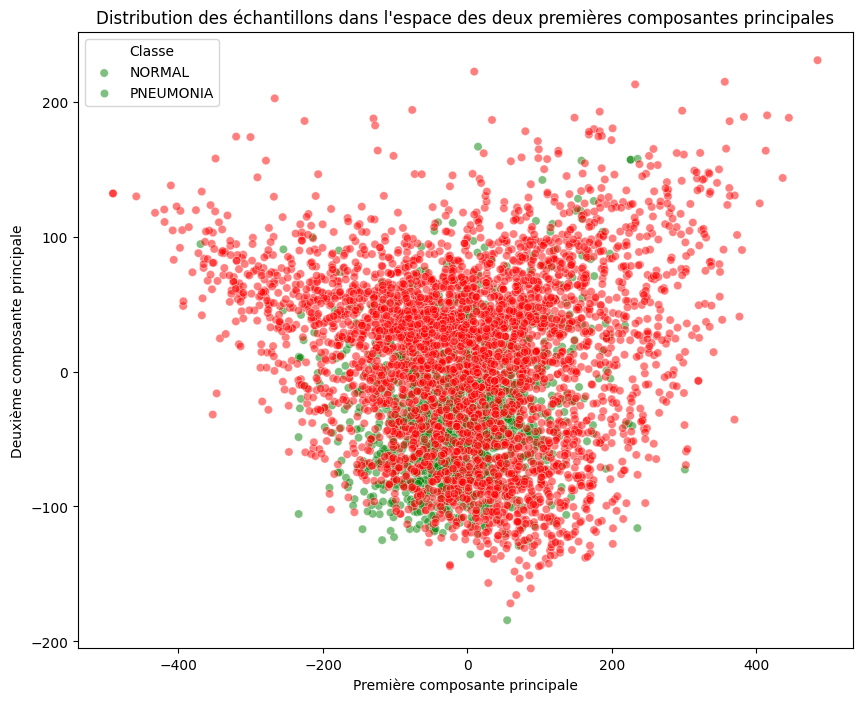

Test avec 70.0% de variance expliquée...
Test avec 80.0% de variance expliquée...
Test avec 90.0% de variance expliquée...
Test avec 95.0% de variance expliquée...
Test avec 99.0% de variance expliquée...

Impact du seuil de variance sur les performances:
  Variance  N Composantes        Score CV
0      70%             15  0.937 (±0.017)
1      80%             39  0.942 (±0.035)
2      90%            190  0.934 (±0.017)
3      95%            611  0.945 (±0.033)
4      99%           2682  0.949 (±0.029)


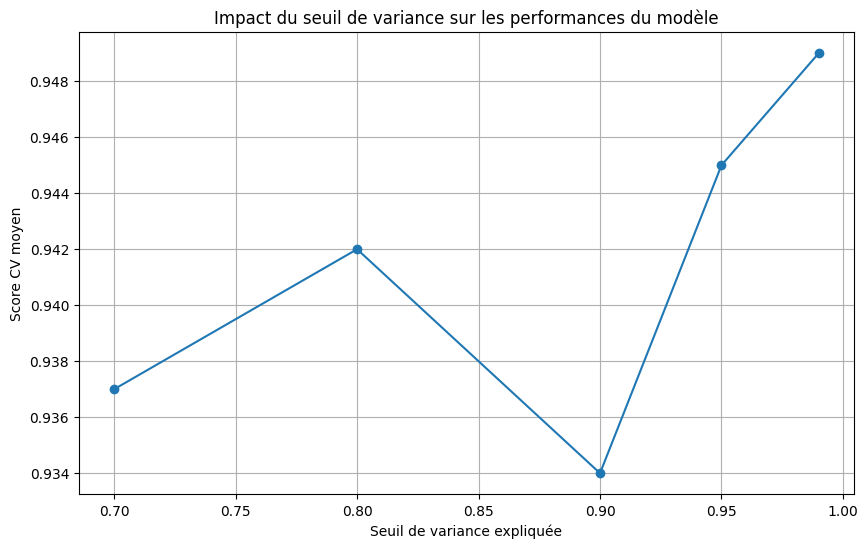

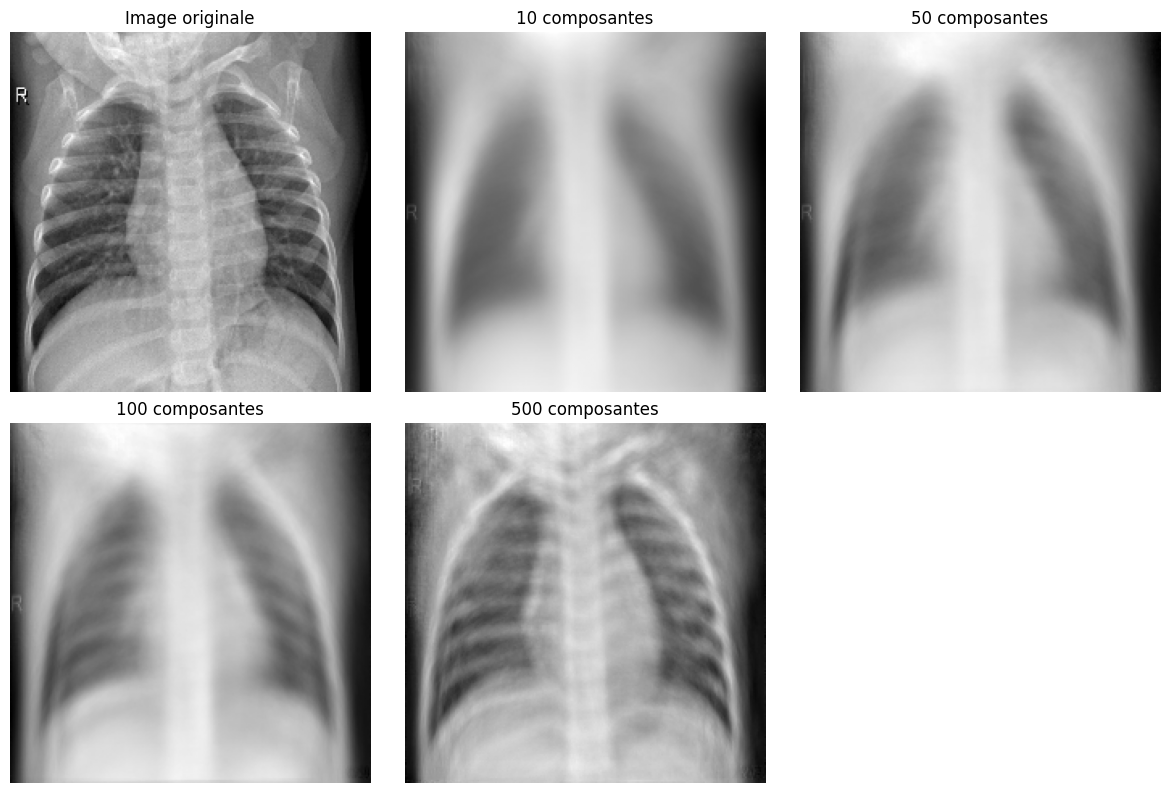

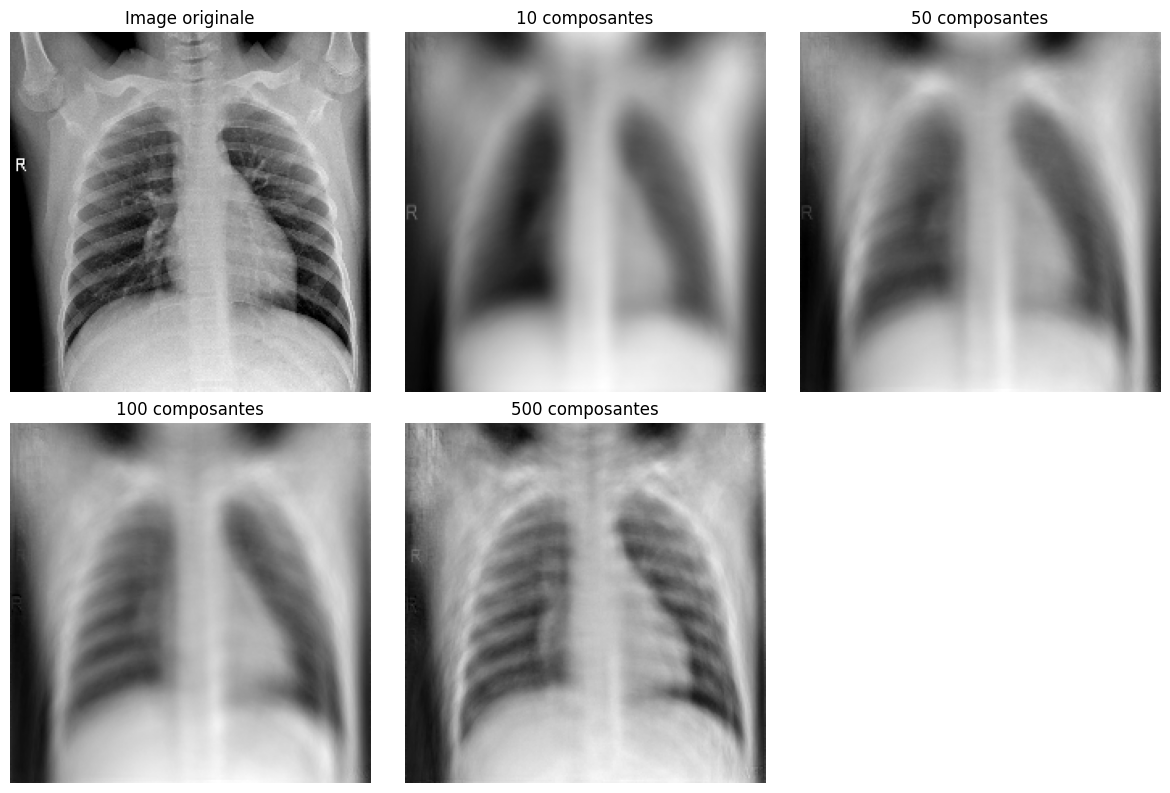

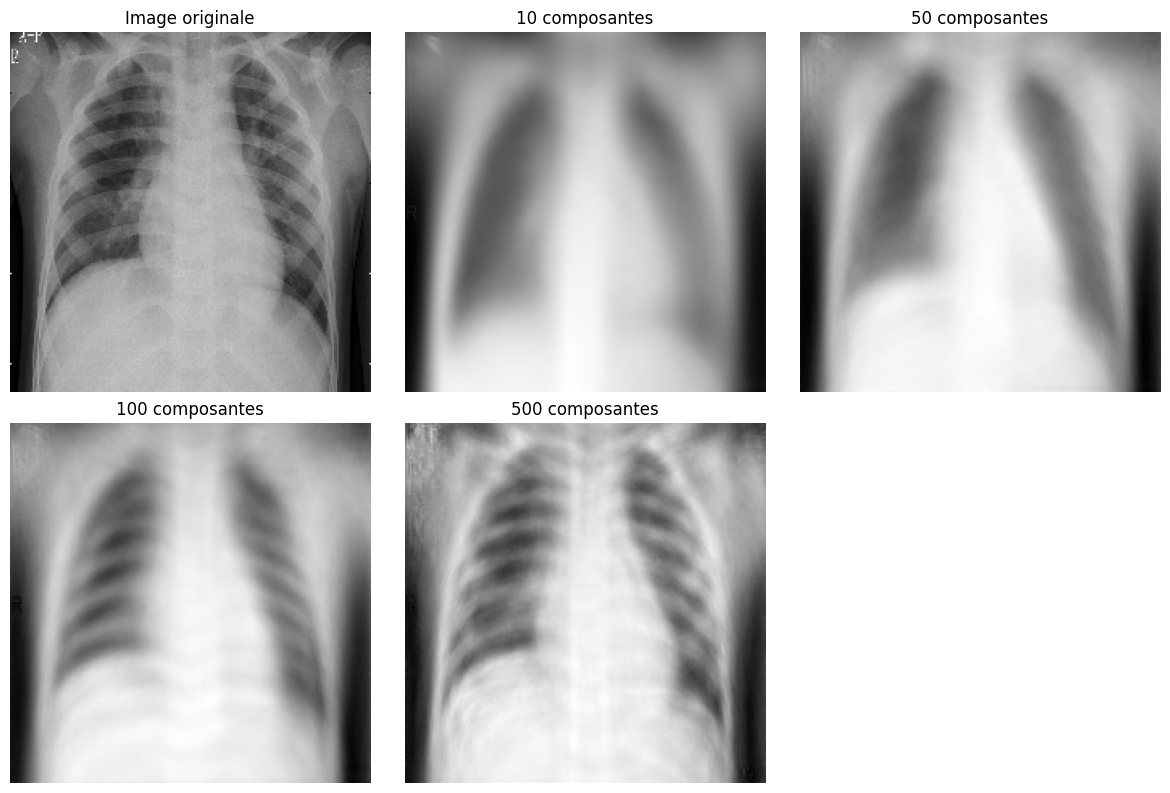

Exception ignored in: <function ResourceTracker.__del__ at 0x1052685e0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104e685e0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from time import time

BASE_DIR = os.path.abspath("..")
PROC_DIR = os.path.join(BASE_DIR, "processed")
CLASSES = ["NORMAL", "PNEUMONIA"]

def load_split(split):
    X, y = [], []
    for idx, cls in enumerate(CLASSES):
        pattern = os.path.join(PROC_DIR, split, cls, "*.png")
        for fp in glob.glob(pattern):
            img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
            arr = img.ravel()
            X.append(arr)
            y.append(idx)
    return np.vstack(X), np.array(y)

print("Chargement des données...")
X_train, y_train = load_split("train")
X_val, y_val = load_split("val")
X_test, y_test = load_split("test")
print("Données chargées.")

print("Standardisation des données...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
print("Données standardisées.")

# Analyse PCA
print("Exécution de l'ACP...")
start_time = time()
pca = PCA()
pca.fit(X_train_scaled)
end_time = time()
print(f"ACP terminée en {end_time - start_time:.2f} secondes.")

# Variance par composante
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée cumulée en fonction du nombre de composantes')
plt.grid(True)
plt.savefig('../reports/pca/pca_cumulative_variance.png', dpi=150, bbox_inches='tight')
plt.show()

# Nb de composantes (95% de variance)
cumsum = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum >= 0.95) + 1
print(f"Nombre de composantes nécessaires pour 95% de variance: {n_components_95}")
print(f"Réduction de dimensionnalité: {X_train.shape[1]} -> {n_components_95} ({n_components_95/X_train.shape[1]*100:.2f}%)")

# Visu PCA
n_components_visual = min(10, n_components_95)
plt.figure(figsize=(15, 8))
for i in range(n_components_visual):
    plt.subplot(2, 5, i+1)
    component = pca.components_[i].reshape(224, 224)
    plt.imshow(component, cmap='viridis')
    plt.title(f"CP {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('../reports/pca/pca_components_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

X_train_pca = pca.transform(X_train_scaled)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, 
                palette=['green', 'red'], alpha=0.5)
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.title('Distribution des échantillons dans l\'espace des deux premières composantes principales')
plt.legend(title='Classe', labels=['NORMAL', 'PNEUMONIA'])
plt.savefig('../reports/pca/pca_sample_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

variance_thresholds = [0.7, 0.8, 0.9, 0.95, 0.99]
cv_scores = []

sample_size = min(1000, len(X_train))
indices = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample, y_train_sample = X_train[indices], y_train[indices]

for threshold in variance_thresholds:
    print(f"Test avec {threshold*100}% de variance expliquée...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=threshold)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    
    scores = cross_val_score(pipeline, X_train_sample, y_train_sample, cv=3, n_jobs=-1)
    n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= threshold) + 1
    
    cv_scores.append({
        'Variance': f"{threshold*100:.0f}%",
        'N Composantes': n_components,
        'Score CV': f"{scores.mean():.3f} (±{scores.std()*2:.3f})"
    })

cv_scores_df = pd.DataFrame(cv_scores)
print("\nImpact du seuil de variance sur les performances:")
print(cv_scores_df)

plt.figure(figsize=(10, 6))
variances = [float(x.split('%')[0])/100 for x in cv_scores_df['Variance']]
mean_scores = [float(x.split()[0]) for x in cv_scores_df['Score CV']]
plt.plot(variances, mean_scores, marker='o')
plt.xlabel('Seuil de variance expliquée')
plt.ylabel('Score CV moyen')
plt.title('Impact du seuil de variance sur les performances du modèle')
plt.grid(True)
plt.savefig('../reports/pca/pca_variance_impact.png', dpi=150, bbox_inches='tight')
plt.show()

def plot_reconstruction(X, pca, image_index, n_components_list):
    X_img = X[image_index].reshape(1, -1)
    X_img_scaled = scaler.transform(X_img)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    original_img = X_img.reshape(224, 224)
    plt.imshow(original_img, cmap='gray')
    plt.title("Image originale")
    plt.axis('off')
    
    for i, n_comp in enumerate(n_components_list):
        X_reduced = pca.transform(X_img_scaled)[:, :n_comp]
        X_reconstructed = pca.inverse_transform(np.pad(X_reduced, ((0, 0), (0, pca.n_components_ - n_comp)), 'constant'))
        X_reconstructed = scaler.inverse_transform(X_reconstructed)
        
        plt.subplot(2, 3, i+2)
        img_reconstructed = X_reconstructed.reshape(224, 224)
        plt.imshow(img_reconstructed, cmap='gray')
        plt.title(f"{n_comp} composantes")
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(f'../reports/pca/pca_reconstruction_image{image_index}.png', dpi=150, bbox_inches='tight')
    plt.show()

n_components_to_test = [10, 50, 100, 500]
for img_idx in [42, 1337, 2500]:
    plot_reconstruction(X_train, pca, img_idx, n_components_to_test)